# Cloud estimation

This script presents an approach to estimating cloud clover at day and at night. Cloud cover estimation could be used as a tool to assist the Sky360 tracker to adapt to challenging conditions. Dynamic backgrounds are particularly difficult for motion detection and tracking, including background subtraction where movement of clouds and changes in light against clouds can cause false positives. The most challenging conditions are likely to be partially cloudy at sunset and sunrise. Whereas the optimal conditions experienced with a perfectly clear sky. 

Imports and functions for calculating normalised B-R ratio and minimum cross entropy:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import cv2 
import math
import os

def br_norm(img, mask):
    b, g, r = cv2.split(img)
    r = np.where(r == 0, 1, r)
    r = r.astype(np.float32)
    b = b.astype(np.float32)
    lambda_n = np.where(mask, (b - r) / (b + r), 0)
    return lambda_n
    
def find_threshold_mce(img):

    StArray = img.ravel()
    x = np.linspace(-1,1,201)
    y, bins = np.histogram(StArray, bins=x)

    MinValue = np.min(StArray)
    MaxValue = np.max(StArray)

    t_int_decimal= MinValue+((MaxValue-MinValue)/2);
    t_int = np.ceil(t_int_decimal*100)/100;
    index_of_t_int = np.argmin(np.abs(x - t_int))

    m0a = 0
    m1a = 0
    for i in range(index_of_t_int):
        m0a += y[i]
        m1a += x[i] * y[i]
        
    m0b = 0
    m1b = 0
    for i in range(index_of_t_int, 200):
        m0b += y[i]
        m1b += x[i] * y[i]

    mu_a=(m1a/m0a)
    mu_b=(m1b/m0b)

    if mu_a < 0:
        mu_a = abs(mu_a)

    diff=5

    t_n_decimal=((mu_b-mu_a) /(np.log(mu_b)-np.log(mu_a)))
    t_n = np.ceil(t_n_decimal*100)/100; 

    iter = 1
    while True:
        # print("Present iteration:", iter)
        t_int = t_n
        
        # Finding index of t_int
        for i in range(201):
            if x[i] == t_int:
                index_of_t_int = i
                break
        
        m0a = 0
        m1a = 0
        for i in range(index_of_t_int):
            m0a += y[i]
            m1a += x[i] * y[i]
            
        m0b = 0
        m1b = 0
        for i in range(index_of_t_int, 200):
            m0b += y[i]
            m1b += x[i] * y[i]
        
        mu_a = m1a/m0a
        mu_b = m1b/m0b

        if mu_a < 0:
            mu_a = abs(mu_a)
        
        t_nplus1_decimal = (mu_b - mu_a) / (np.log(mu_b) - np.log(mu_a))
        t_nplus1 = math.ceil(t_nplus1_decimal * 100) / 100
        
        diff = abs(t_nplus1 - t_n)
        t_n = t_nplus1
        
        if diff == 0:
            break
        
        iter += 1

    ThresholdValue = t_n

    return ThresholdValue

## Day time

The method used here is taken from Li et al (2011) who first transform an input color cloud image into a normalized blue/red channel ratio image that keeps distinct contrast. They then perform some basic detection of cloud conditions using the standard deviation the BR image before determining an appropriate threshold level to derive a cloud mask. 

We will start by reading some frames. *Add further images to the folder in png format if required. The code here assumes all images are 2880x2880 from the Sky360 dataset.*

In [2]:
image_dir = 'day_frames'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

images = np.empty((len(image_files),), dtype=np.ndarray)
for i, image_file in enumerate(image_files):
    img = cv2.imread(os.path.join(image_dir, image_file))
    images[i] = img

Plot originals

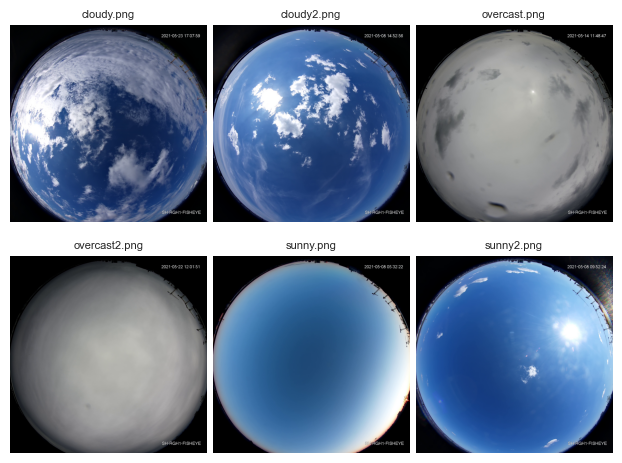

In [3]:
n_images = len(images)
ncols = 3
nrows = (n_images + ncols - 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.subplots_adjust(left=0, right=1.2, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i, ax in enumerate(axs.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.set(xticks=[], yticks=[])
    ax.set_title(image_files[i],fontsize=8)
    ax.axis('off')

fig.tight_layout()
plt.show()

Mask objects around the periphery of the field of view. A simple circular mask is applied here.

In [4]:
height, width, _ = images[0].shape
x, y = np.ogrid[:width, :height]
center_x, center_y = width // 2, height // 2
radius = 1070
mask = (x - center_x)**2 + (y - center_y)**2 < radius**2

Compute the normalised BR ratio $\lambda_N$ for each image over the circular area i.e.

$\lambda_N=\dfrac{b-r}{b+r}$

where $b$ and $r$ are blue and red channels of RB ratio image respectively.

Plot normalised BR ratio image with mask applied.

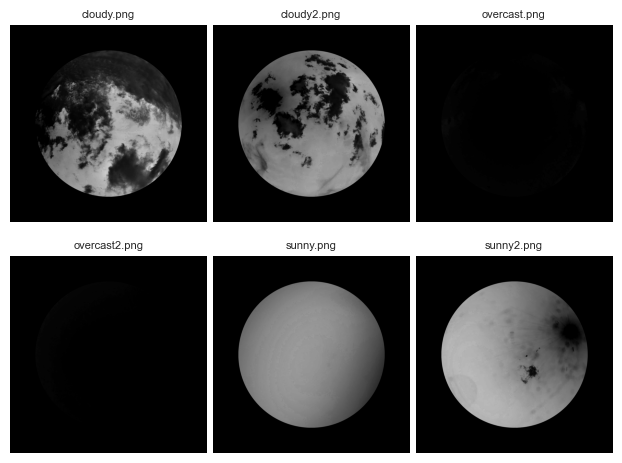

In [5]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.subplots_adjust(left=0, right=1.2, bottom=0, top=1, hspace=0.05, wspace=0.05)

lambda_n = np.empty((len(image_files),), dtype=np.ndarray)
for i, ax in enumerate(axs.flat):
    lambda_n[i] = br_norm(images[i], mask)
    ax.imshow(cv2.cvtColor(np.clip(lambda_n[i], 0, 1), cv2.COLOR_BGR2RGB))
    ax.set_title(image_files[i],fontsize=8)
    ax.axis('off')

fig.tight_layout()

Now if you examine the histogram of BR ratio image you will see that overcast and sunny conditions typically have a unimodal distribution, whereas (partially) cloudy conditions have a bimodal distribution.

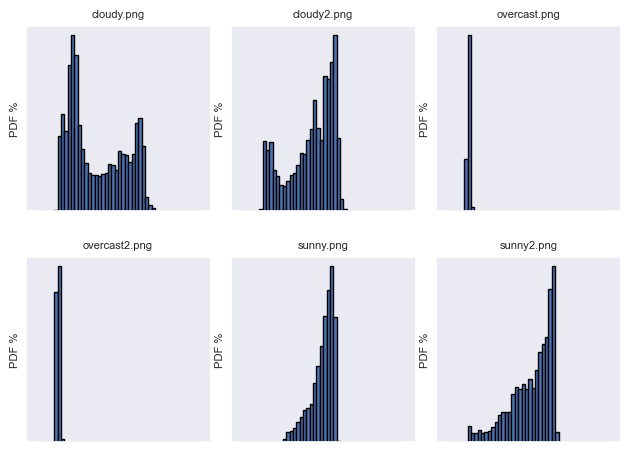

In [6]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.subplots_adjust(left=0, right=1.2, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i, ax in enumerate(axs.flat):
    ax.hist(lambda_n[i][mask], bins=50, density=True, range=(-0.2, 1.2), edgecolor = "black")
    ax.set_title(image_files[i],fontsize=8)
    ax.set_ylabel('PDF %', fontsize=8)
    ax.set(xticks=[], yticks=[])
    ax.set_aspect(1./ax.get_data_ratio())

fig.tight_layout()

Li et al (2011) propose that detection of a bimodal distribution in a BR image can be determined from standard deviation. They uses a magic number of 0.03 i.e. when over 0.03 it will be bimodal, less than unimodal. A more sophisticated method could be used here e.g. kmeans. However this seems to work well and may be enough for our purposes.

If unimodal a fixed thresholding value is used to derive a 8-bit binary cloud mask. For bimodal an adaptive threshold is computed using the minimum cross entropy (MCE) function. The MCE algorithm selects a threshold by minimizing the cross entropy between the original image and its segmented image.

Once we have a cloud mask it is a simple matter to count the black pixels out of the segmented image to determine cloud cover ratio $CCR$ as a percentage.

$CCR=\dfrac{N_{cloud}}{N_{sky} + N_{cloud}} \times 100$

where $N_{cloud}$ is the number of cloud pixels and $N_{sky}$ is the number of sky pixels in an all-sky image (masked pixels not included)


Processing image: cloudy.png
Bimodal distribution
Cloud cover: 45.86%

Processing image: cloudy2.png
Bimodal distribution
Cloud cover: 19.91%

Processing image: overcast.png
Unimodal distribution
Cloud cover: 100.0%

Processing image: overcast2.png
Unimodal distribution
Cloud cover: 100.0%

Processing image: sunny.png
Bimodal distribution
Cloud cover: 0.0%

Processing image: sunny2.png
Bimodal distribution
Cloud cover: 6.45%



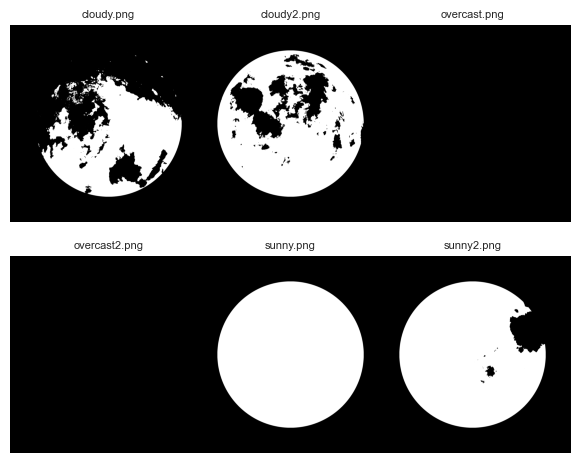

In [7]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.subplots_adjust(left=0, right=1.5, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i, ax in enumerate(axs.flat):
    std = np.std(lambda_n[i][mask])
    print("Processing image: " + image_files[i])
    # print("Standard deviation: " + str(std))
    if std > 0.03: # magic number
        print("Bimodal distribution")
        threshold = find_threshold_mce(lambda_n[i])
        _, ratio_mask = cv2.threshold(lambda_n[i], threshold, 255, cv2.THRESH_BINARY)
    else:
        print("Unimodal distribution")
        _, ratio_mask = cv2.threshold(lambda_n[i], 0.25, 255, cv2.THRESH_BINARY)

    ax.imshow(ratio_mask, cmap='gray')
    ax.axis('off')  
    ax.set_title(image_files[i],fontsize=8)

    # Count the number of pixels in each part of the mask
    N_Cloud = np.count_nonzero(ratio_mask[mask] == 0)
    N_Sky = np.count_nonzero(ratio_mask[mask])

    # Cloud cover ratio
    ccr = (N_Cloud / (N_Cloud + N_Sky)) * 100
    print(f'Cloud cover: {round(ccr,2)}%')
    print(f'')
    
fig.tight_layout()

## Night time

The approach above does not work particularly well for greyscale / night images. There tends to be an over estimation of the cloud mask.

Research points to Otsu thesholding being fairly effective (see Gao et al 2022) - again this is an adaptive thresholding approach so more computationally demanding. However, if using this for Sky360 it could be computed infrequently e.g. a frame every few minutes.

In [8]:
image_dir = 'night_frames'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

images = np.empty((len(image_files),), dtype=np.ndarray)
for i, image_file in enumerate(image_files):
    img = cv2.imread(os.path.join(image_dir, image_file),0)
    images[i] = img

Show original night time images

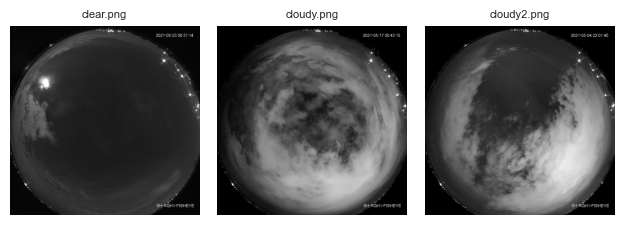

In [9]:
n_images = len(images)
ncols = 3
nrows = (n_images + ncols - 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.subplots_adjust(left=0, right=1.2, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i],cmap='gray')
    ax.set(xticks=[], yticks=[])
    ax.set_title(image_files[i],fontsize=8)
    ax.axis('off')

fig.tight_layout()
plt.show()

Calculate Otsu Threshold and display resulting cloud masks

Processing image: clear.png
Cloud cover: 6.43%

Processing image: cloudy.png
Cloud cover: 64.82%

Processing image: cloudy2.png
Cloud cover: 45.42%



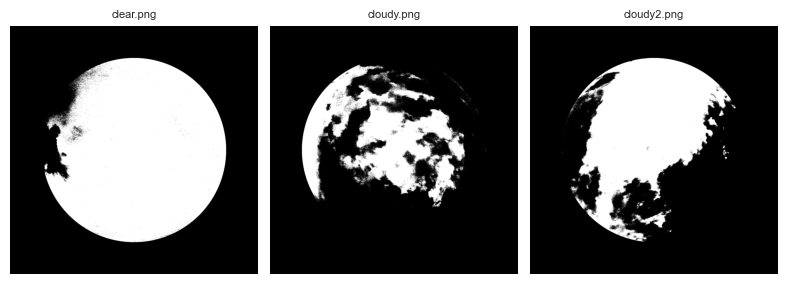

In [10]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.subplots_adjust(left=0, right=1.2, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i, ax in enumerate(axs.flat):
    print("Processing image: " + image_files[i])
    otsu_threshold, image_result = cv2.threshold(
        images[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
    )

    # Count the number of non zero pixels (white)
    N_Cloud = np.count_nonzero(image_result[mask])
    N_Sky = np.count_nonzero(image_result[mask] == 0)
    
    ccr = (N_Cloud / (N_Cloud + N_Sky)) * 100
    print(f'Cloud cover: {round(ccr,2)}%')
    print(f'')

    image_result = cv2.bitwise_not(image_result)
    image_result = cv2.bitwise_and(image_result, image_result, mask=mask.astype('uint8'))
    ax.imshow(image_result, cmap='gray')
    ax.axis('off')  
    ax.set_title(image_files[i],fontsize=8)

## References

- Li, Qingyong & Lyu, Weitao & Yang, Jun. (2011). A Hybrid Thresholding Algorithm for Cloud Detection on Ground-Based Color Images. Journal of Atmospheric and Oceanic Technology. 28. 1286-1296. 10.1175/JTECH-D-11-00009.1. 
https://journals.ametsoc.org/view/journals/atot/28/10/jtech-d-11-00009_1.xml?tab_body=fulltext-display

- Gao, Baoquan & Ping, Yiding & Lu, Yao & Zhang, Chen. (2022). Nighttime Cloud Cover Estimation Method at the Saishiteng 3850 m Site. Universe. 8. 538. 10.3390/universe8100538. 
https://www.mdpi.com/2218-1997/8/10/538